In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cpu


In [4]:
# Load scaled tabular features
X_tab = np.loadtxt(
    "data/processed/train_tabular.csv",
    delimiter=",",
    skiprows=1
)

print("Tabular shape:", X_tab.shape)


Tabular shape: (16209, 10)


In [5]:
# Load raw price and log-transform
df_raw = pd.read_excel("data/raw/train(1).xlsx")
y = np.log1p(df_raw["price"].values)

print("Target shape:", y.shape)



Target shape: (16209,)


In [6]:
X_img = np.load("data/processed/image_embeddings.npy")

print("Image embeddings shape:", X_img.shape)


Image embeddings shape: (1200, 2048)


In [7]:
num_images = X_img.shape[0]

X_tab = X_tab[:num_images]
y = y[:num_images]

print("After alignment:")
print("X_tab:", X_tab.shape)
print("X_img:", X_img.shape)
print("y:", y.shape)


After alignment:
X_tab: (1200, 10)
X_img: (1200, 2048)
y: (1200,)


In [8]:
X_tab_tr, X_tab_val, X_img_tr, X_img_val, y_tr, y_val = train_test_split(
    X_tab,
    X_img,
    y,
    test_size=0.2,
    random_state=42
)

print("Train samples:", X_tab_tr.shape[0])
print("Val samples:", X_tab_val.shape[0])


Train samples: 960
Val samples: 240


In [10]:
class FusionModel(nn.Module):
    def __init__(self, tab_dim, img_dim):
        super().__init__()

        self.tabular_branch = nn.Sequential(
            nn.Linear(tab_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.image_branch = nn.Sequential(
            nn.Linear(img_dim, 448),
            nn.BatchNorm1d(448),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.fusion = nn.Sequential(
            nn.Linear(128 + 448, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x_tab, x_img):
        t = self.tabular_branch(x_tab)
        i = self.image_branch(x_img)
        x = torch.cat([t, i], dim=1)
        return self.fusion(x)


In [11]:
model = FusionModel(
    tab_dim=X_tab.shape[1],
    img_dim=X_img.shape[1]
).to(device)

print(model)


FusionModel(
  (tabular_branch): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (image_branch): Sequential(
    (0): Linear(in_features=2048, out_features=448, bias=True)
    (1): BatchNorm1d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (fusion): Sequential(
    (0): Linear(in_features=576, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [13]:
EPOCHS = 40

for epoch in range(EPOCHS):
    model.train()

    x_tab_t = torch.tensor(X_tab_tr, dtype=torch.float32).to(device)
    x_img_t = torch.tensor(X_img_tr, dtype=torch.float32).to(device)
    y_t = torch.tensor(y_tr, dtype=torch.float32).to(device)

    optimizer.zero_grad()
    preds = model(x_tab_t, x_img_t).squeeze()
    loss = criterion(preds, y_t)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {loss.item():.4f}")


Epoch [5/40] - Train Loss: 79.3689
Epoch [10/40] - Train Loss: 8.9062
Epoch [15/40] - Train Loss: 14.6767
Epoch [20/40] - Train Loss: 8.2923
Epoch [25/40] - Train Loss: 1.2930
Epoch [30/40] - Train Loss: 3.3443
Epoch [35/40] - Train Loss: 1.8780
Epoch [40/40] - Train Loss: 0.7377


In [14]:
model.eval()

with torch.no_grad():
    x_tab_v = torch.tensor(X_tab_val, dtype=torch.float32).to(device)
    x_img_v = torch.tensor(X_img_val, dtype=torch.float32).to(device)
    y_v = torch.tensor(y_val, dtype=torch.float32).to(device)

    val_preds = model(x_tab_v, x_img_v).squeeze().cpu().numpy()


In [15]:
rmse = root_mean_squared_error(y_val, val_preds)
r2 = r2_score(y_val, val_preds)

print("Validation RMSE:", rmse)
print("Validation R²:", r2)


Validation RMSE: 2.0212911181196347
Validation R²: -16.17023018966688


In [16]:

torch.save({
    "model_state_dict": model.state_dict(),
    "tabular_dim": X_tab.shape[1],
    "image_dim": X_img.shape[1]
}, "fusion_model.pth")

print("Multimodal fusion model saved as fusion_model.pth")


Multimodal fusion model saved as fusion_model.pth


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    random_state=42
)

rf.fit(X_tab_tr, y_tr)
rf_preds = rf.predict(X_tab_val)

rmse_rf = root_mean_squared_error(y_val, rf_preds)
r2_rf = r2_score(y_val, rf_preds)

print("Tabular RF RMSE:", rmse_rf)
print("Tabular RF R²:", r2_rf)


Tabular RF RMSE: 0.3280180851427881
Tabular RF R²: 0.5478172817367357


In [18]:
print("========== FINAL MODEL COMPARISON ==========")
print(f"Tabular RF   → RMSE: {rmse_rf:.3f}, R²: {r2_rf:.3f}")
print(f"Multimodal   → RMSE: {rmse:.3f}, R²: {r2:.3f}")


========== FINAL MODEL COMPARISON ==========
Tabular RF   → RMSE: 0.328, R²: 0.548
Multimodal   → RMSE: 2.021, R²: -16.170


In [19]:

import joblib

joblib.dump(rf, "tabular_rf_model.pkl")
print("Tabular RF model saved as tabular_rf_model.pkl")


Tabular RF model saved as tabular_rf_model.pkl


c:\Users\User\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\User\anaconda3\envs\ml\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._ma

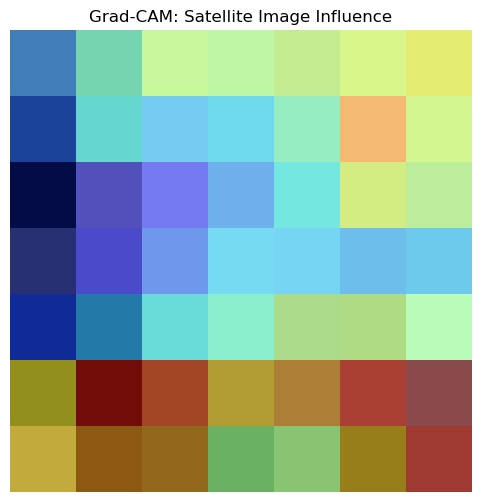

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image

cnn = models.resnet50(pretrained=True)
cnn.eval()

gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def forward_hook(module, input, output):
    global activations
    activations = output


target_layer = cnn.layer4[-1]
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def generate_gradcam(img_path):
    global gradients, activations

    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)

    cnn.zero_grad()
    output = cnn(input_tensor)
    score = output.mean()
    score.backward()

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.detach().numpy(), 0)
    heatmap /= heatmap.max()

    return heatmap, img

heatmap, original_img = generate_gradcam("data/images/0.png")

plt.figure(figsize=(6,6))
plt.imshow(original_img)
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.title("Grad-CAM: Satellite Image Influence")
plt.axis("off")
plt.show()



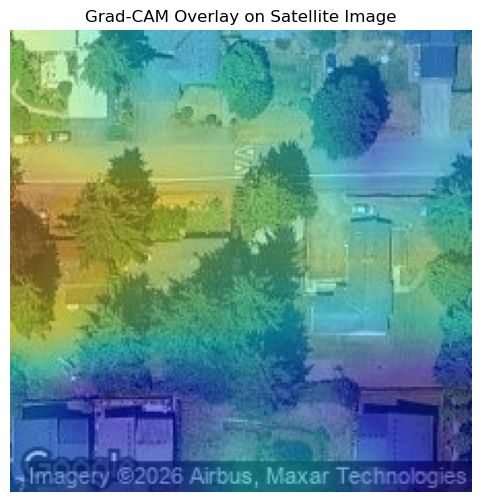

In [45]:


def overlay_gradcam(img_path, heatmap):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(
        np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET
    )
    overlay = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.title("Grad-CAM Overlay on Satellite Image")
    plt.axis("off")
    plt.show()

overlay_gradcam("data/images/0.png", heatmap)
